# Lucas_task 15 - Motor Control
### Introduction to modeling and simulation of human movement
https://github.com/BMClab/bmc/blob/master/courses/ModSim2018.md

Implement a simulation of the ankle joint model using the parameters from Thelen (2003) and Elias (2014)

In [1]:
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import math
from Muscle import Muscle

In [2]:
Lslack_TA = 2.4*0.09 # tendon slack length
Lce_o_TA  = 0.09 # optimal muscle fiber length
Fmax_TA   = 1400 #maximal isometric DF force
alpha_TA  = 7*math.pi/180 # DF muscle fiber pennation angle

dt = 0.0001

In [3]:
Lslack_Sol = 8.8*0.03 # tendon slack length
Lce_o_Sol  = 0.03 # optimal muscle fiber length
Fmax_Sol   = 9500 #maximal isometric DF force
alpha_Sol  = 25*math.pi/180 # DF muscle fiber pennation angle


In [4]:
dorsiflexor = Muscle(Lce_o=Lce_o_TA, Fmax=Fmax_TA, Lslack=Lslack_TA, alpha=alpha_TA, dt = dt)
soleus = Muscle(Lce_o=Lce_o_Sol, Fmax=Fmax_Sol, Lslack=Lslack_Sol, alpha=alpha_Sol, dt =  dt)

In [5]:
soleus.Fmax

9500

### Muscle properties

Parameters from Nigg & Herzog (2006).

In [6]:
Umax  = 0.04 # SEE strain at Fmax
width = 0.63 # Max relative length change of CE

Activation dynamics parameters

In [7]:
a = 1
u = 1 #Initial conditional for Brain's activation
#b = .25*10#*Lce_o 

## Subject's anthropometrics
Parameters obtained experimentally or from Winter's book.

In [8]:
M      = 75 #total body mass (kg)
Lseg   = 0.26 #segment length (m)
m      = 0.0145*M #foot mass (kg)
g      = 9.81 #acceleration of gravity (m/s2)
Rcm    = Lseg*0.5 #distance from ankle joint to center of mass (m)
I      = m*(0.69*Lseg)**2 #moment of inertia
legAng = math.pi/2 #angle of the leg with horizontal (90 deg)

In [9]:
As_TA = np.array([30.6, -7.44e-2, -1.41e-4, 2.42e-6, 1.5e-8]) / 100   # at [m] instead of [cm]
# Coefs for moment arm for ankle angle
Bs_TA = np.array([4.3, 1.66e-2, -3.89e-4, -4.45e-6, -4.34e-8]) / 100  # at [m] instead of [cm]
As_SOL = np.array([32.3, 7.22e-2, -2.24e-4, -3.15e-6, 9.27e-9]) / 100   # at [m] instead of [cm]
Bs_SOL = np.array([-4.1, 2.57e-2, 5.45e-4, -2.22e-6, 5.5e-9]) / 100   # at [m] instead of [cm]

### Initial conditions

In [10]:
phi = 0
phid = 0 #zero velocity
Lm0  = 0.31 #initial total lenght of the muscle
dorsiflexor.Lnorm_ce = .087/dorsiflexor.Lce_o #norm
soleus.Lnorm_ce = .03/soleus.Lce_o #norm
t0 = 0 #Initial time
tf = 20 #Final Time


In [11]:

t = np.arange(t0,tf,dt) # time array
# preallocating
F          = np.empty((t.shape[0],2))
phivec     = np.empty(t.shape)
Fkpe       = np.empty(t.shape)
FiberLen   = np.empty(t.shape)
TendonLen  = np.empty(t.shape)
a_dynamics = np.empty(t.shape)
Moment     = np.empty(t.shape)

## Simulation - Series

In [12]:
def ComputeMomentJoint(Rf_TA, Fnorm_tendon_TA, Fmax_TA, Rf_SOL, Fnorm_tendon_SOL, Fmax_SOL, m, g, phi):
    '''
    Inputs:
        RF = Moment arm
        Fnorm_tendon = Normalized tendon force
        m = Segment Mass
        g = Acelleration of gravity
        Fmax= maximal isometric force
    Output:
        M = Total moment with respect to joint
    '''
    M = Rf_TA*Fnorm_tendon_TA*Fmax_TA + Rf_SOL*Fnorm_tendon_SOL*Fmax_SOL - m*g*Rcm*np.sin(legAng - phi)
    return M

In [13]:
def ComputeAngularAcelerationJoint(M, I):
    '''
    Inputs:
        M = Total moment with respect to joint
        I = Moment of Inertia
    Output:
        phidd= angular aceleration of the joint
    '''
    phidd = M/I
    return phidd

In [14]:
def computeMomentArmJoint(theta, Bs):
    # theta - joint angle (degrees)
    # Bs - coeficients for the polinomio

    auxBmultp = np.empty(Bs.shape);
    for i in range (len(Bs)):
        auxBmultp[i] = Bs[i] * (theta**i)

    Rf = sum(auxBmultp)

    return Rf

In [15]:
def ComputeTotalLenghtSize(theta, As):
        # theta = joint angle(degrees)
        # As - coeficients for the polinomio

        auxAmultp = np.empty(As.shape);

        for i in range (len(As)):
            auxAmultp[i] = As[i] * (theta**i)

        Lm = sum(auxAmultp)

        return Lm

In [16]:
for i in range (len(t)):
    Lm_TA = ComputeTotalLenghtSize(phi*180/np.pi, As_TA)
    Rf_TA = computeMomentArmJoint(phi*180/np.pi, Bs_TA)
    Lm_SOL = ComputeTotalLenghtSize(phi*180/np.pi, As_SOL)
    Rf_SOL = computeMomentArmJoint(phi*180/np.pi, Bs_SOL)
    ##############################################################
    dorsiflexor.updateMuscle(Lm=Lm_TA, u=0.24)
    soleus.updateMuscle(Lm=Lm_SOL, u=0.3)
    #####################################################################     
    #Compute MomentJoint
    M = ComputeMomentJoint(Rf_TA,dorsiflexor.Fnorm_tendon,dorsiflexor.Fmax,Rf_SOL, soleus.Fnorm_tendon,soleus.Fmax,m,g,phi)
    #Compute Angular Aceleration Joint
    phidd = ComputeAngularAcelerationJoint (M,I)
    # Euler integration steps
    phid= phid + dt*phidd
    phi  = phi  + dt*phid
    phideg= (phi*180)/math.pi #convert joint angle from radians to degree
    # Store variables in vectors
    F[i,0] = dorsiflexor.Fnorm_tendon*dorsiflexor.Fmax
    F[i,1] = soleus.Fnorm_tendon*soleus.Fmax
    Fkpe[i] = dorsiflexor.Fnorm_kpe*dorsiflexor.Fmax
    FiberLen[i] = dorsiflexor.Lnorm_ce*dorsiflexor.Lce_o
    TendonLen[i] = dorsiflexor.Lnorm_see*dorsiflexor.Lce_o
    a_dynamics[i] = soleus.a
    phivec[i] = phideg
    Moment[i] = M

## Plots 

<IPython.core.display.Javascript object>


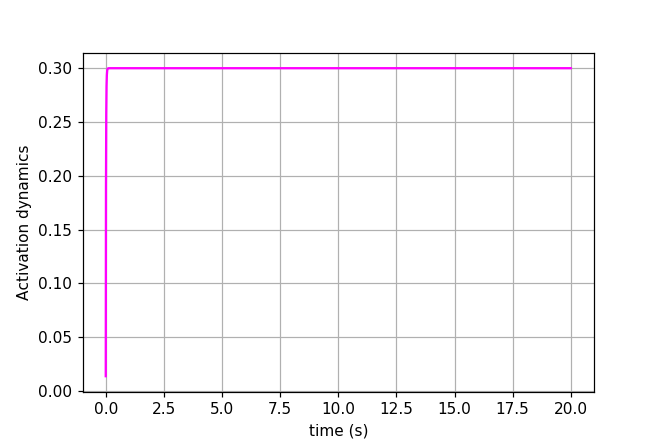

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(t,a_dynamics,c='magenta')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Activation dynamics')
plt.show()

<IPython.core.display.Javascript object>


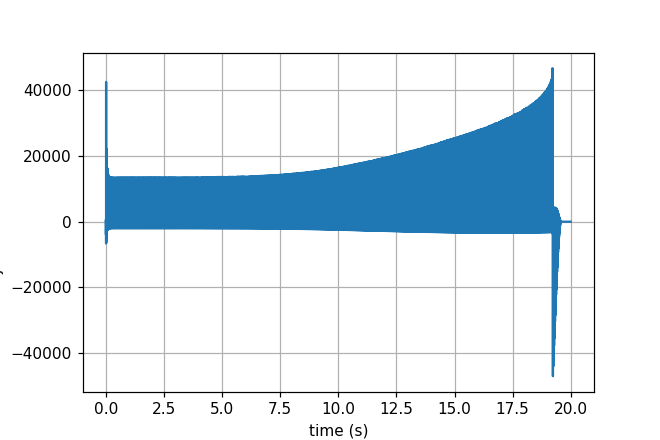

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(t, Moment)
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('joint moment')
plt.show()

<IPython.core.display.Javascript object>


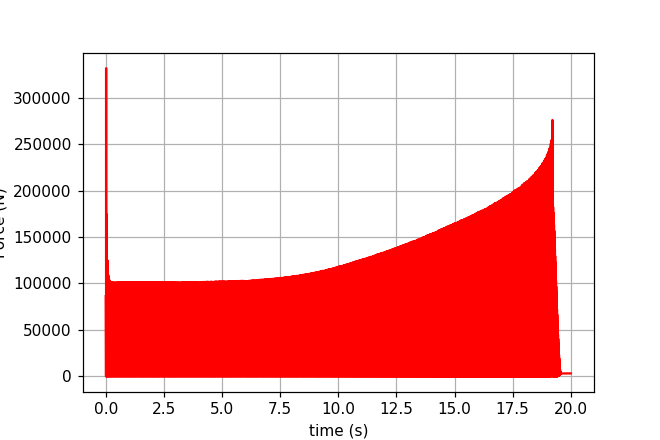

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(t, F[:,1], c='red')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Force (N)')
plt.show()

<IPython.core.display.Javascript object>


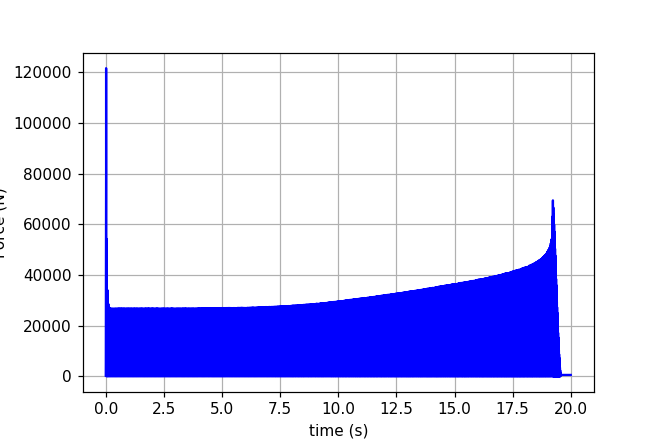

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(t, F[:,0], c='blue')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Force (N)')
plt.show()

<IPython.core.display.Javascript object>


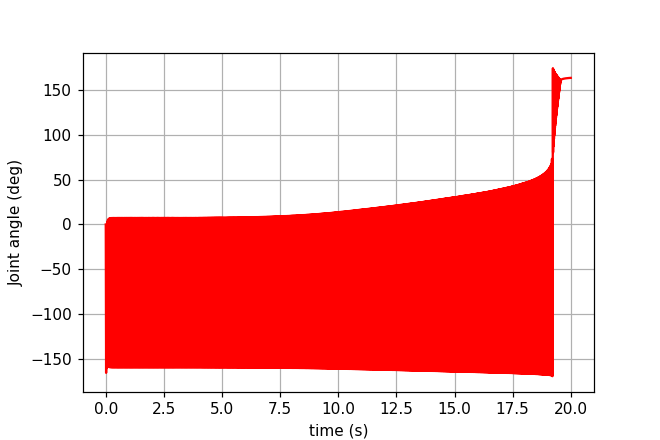

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(t,phivec,c='red')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Joint angle (deg)')
plt.show()

<IPython.core.display.Javascript object>


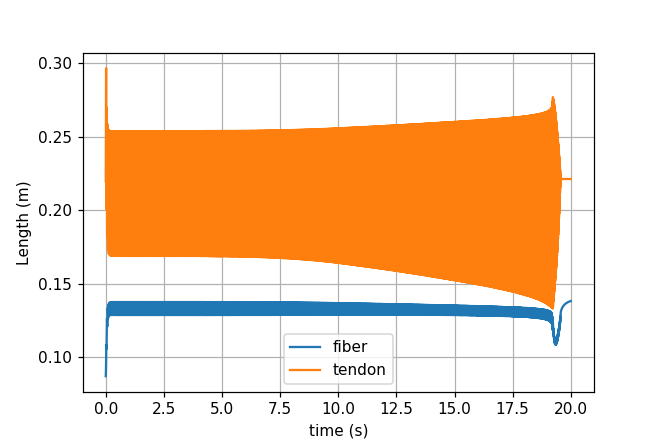

<IPython.core.display.Javascript object>


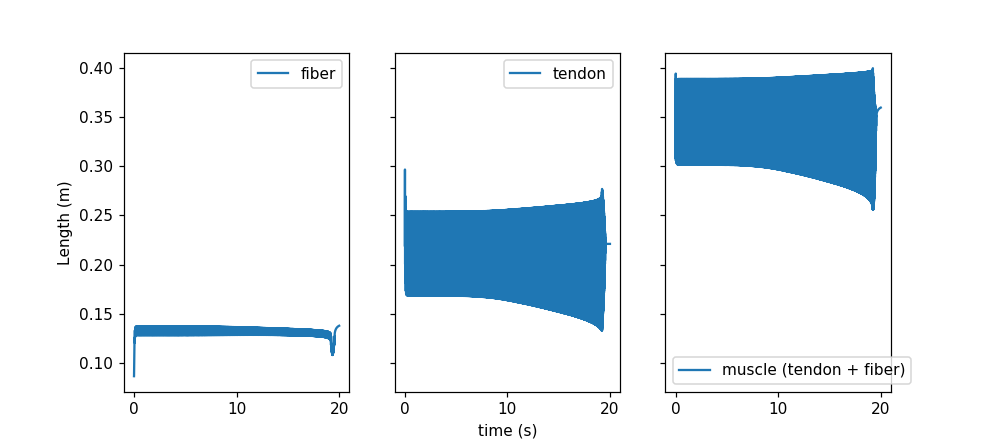

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(t,FiberLen, label = 'fiber')
ax.plot(t,TendonLen, label = 'tendon')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Length (m)')
ax.legend(loc='best')


fig, ax = plt.subplots(1, 3, figsize=(9,4), sharex=True, sharey=True)
ax[0].plot(t,FiberLen, label = 'fiber')
ax[1].plot(t,TendonLen, label = 'tendon')
ax[2].plot(t,FiberLen + TendonLen, label = 'muscle (tendon + fiber)')

ax[1].set_xlabel('time (s)')
ax[0].set_ylabel('Length (m)')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')
plt.show()